# **Predicting Video Memorability Using Features for MediaEval 2018**

**Task:** This is a media analytics task in which we have to design a machine learning algorithm that will be used to predict the memorability of
short video clips using different features available. 

 **ABOUT THIS NOTEBOOK**



PART I.   Mounting Google Drive to Notebook 

PART II.   Importing Libraries required for this notebook.

PART III. Defining Function to calculate Spearman Coefficient Score.

PART IV. Using Different Features.

1.   Using Inception Features
  *   Defining function to read the file.
  *   Loading Features
  *   Merging dataset with same video names.
  *   Pre-Processing Features
  *  **Building Sequential Neural Network Model**
  * Visualizing the results
  * Calculating Spearman's Correlation Coefficient

2.   Using Captions Features
  * Defining Function to load the captions into dataframes and to pre-process the dataset.
  * Giving path to the dataset in the notebook.
  * Cleaning Dataset 
  * Using Bag of Words for the captions
  * Splitting Dataset into Training set and Test set.
  * **Building the RandomForest Model**
  * Calculating Spearman's Correlation Coefficient
  * **Building the Support Vector Regression (SVR) Model**
  * Calculating Spearman's Correlation Coefficient

3.   Using HMP Features
  * Defining Function to load the HMP features and to pre-process the dataset.
  * Fetching HMP features
  * Transforming HMP features into dataframe
  * Merging ground_truth and HMP_features into a dataframe
  * Creating features and Target required for the Model.
  * **Building the Model using RandomForest Regression Model**
  * Calculating Spearman's Correlation Coefficient
  * **Building the Model using Decision Tree Model**
  * Calculating Spearman's Correlation Coefficient.

PART V. Choosing Perfect Model with Features.

PART VI. Predicting the Results.






# **PART I. Mounting Google Drive to Notebook**

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Dev-set')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# **PART II. Importing Libraries required for this notebook.**

In [0]:
!pip install pyprind
import pandas as pd
import numpy as np
import os
import keras
import pyprind
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split #To Create Test Train File
from keras.callbacks import EarlyStopping #To Avoid Overfitting 
import glob
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
nltk.download("stopwords")

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **PART III. Defining Function to calculate Spearman Coefficient Score.**

In [0]:
def Get_spearmann_score(Y_pred,Y_true):
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes mismatch!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearmann\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_spearmann_score(Y_pred[:,ii],Y_true[:,ii])

# **PART IV. Using Different Features**

# **1. Using Inception Features**


**Defining function to read the file**

In [0]:
def read_inception(fname):
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            incept_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    
    incept = np.zeros(6075)
    for idx in incept_temp.keys():
        incept[idx-1] = incept_temp[idx]            
    return incept

**Loading Features**

In [0]:
#Load only features we required in our case it is video and the arrayInfo
df = pd.DataFrame(columns = ['video', 'arrayInfo'])

Incept_feature = '/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Dev-set/InceptionV3'

for filename in os.listdir(Incept_feature):
    if filename.endswith(".txt"):
        path = os.path.join(Incept_feature, filename)
        array = read_inception(path)
        if "-56" in filename:
          filename.replace('-56','')
          fileName= filename.replace(".txt",".webm")
          df = df.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
count=0
for item in df['video']:
  df['video'][count]=item.replace('-56.webm','.webm')
  count = count + 1
  

**Merging dataset with same video names.**

In [0]:
# loading the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'/Ground-truth/ground-truth.csv')

In [13]:
df_inception = df.merge(labels,on=["video"],how="inner") 
df_inception.columns
df_inception.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video7364.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.891,33,0.900,10
1,video737.webm,"[2.826083e-36, 0.0, 0.0, 0.0, 1.199688e-28, 0....",0.914,44,1.000,11
2,video7373.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.954,31,0.917,12
3,video7370.webm,"[2.318133e-24, 3.561454e-29, 2.048143e-24, 4.1...",0.951,33,0.938,16
4,video7372.webm,"[1.123148e-33, 0.0, 0.0, 0.0, 5.879868e-27, 0....",0.960,47,1.000,15


**Pre-Processing Features**

Converting the features into Numpy Array as our Model will only accept numpy-array for features.

In [14]:
array_resulted = np.empty((0, 6075))
array_resulted

array([], shape=(0, 6075), dtype=float64)

In [0]:
for line in df_inception['arrayInfo']:
    array_resulted = np.append(array_resulted, np.array([line]), axis = 0)

In [0]:
arrayInfo = df_inception['arrayInfo'].values

In [17]:
X_arrHMP = array_resulted
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.826083e-36, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [0]:
# Targets and Features
Y=df_inception[['short-term_memorability','long-term_memorability']].values  
X=X_arrHMP 

In [19]:
# Random state so that we can produce same results over and over again.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) 

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


In [20]:
n_cols = X_train.shape[1]
n_cols

6075

**Building Sequential Neural Network Model**

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dense(100, activation='relu'))# Second layer
model.add(Dense(2))# Output layer

In [0]:
# Compile the model
# We will use optimizer adam here and the metrics Accuracy.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) 
   
# Define early_stopping_monitor
# And used EarlyStopping to avoid any overfitting. 
early_stopping_monitor = EarlyStopping(patience=2) 

In [153]:
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=20, callbacks= [early_stopping_monitor])


Train on 3360 samples, validate on 1440 samples
Epoch 1/20
3360/3360 [==============================] - 1s 401us/step - loss: 0.1045 - accuracy: 0.6256 - val_loss: 0.0130 - val_accuracy: 0.7090
Epoch 2/20
3360/3360 [==============================] - 1s 368us/step - loss: 0.0135 - accuracy: 0.7030 - val_loss: 0.0129 - val_accuracy: 0.7090
Epoch 3/20
3360/3360 [==============================] - 1s 382us/step - loss: 0.0134 - accuracy: 0.7030 - val_loss: 0.0128 - val_accuracy: 0.7090
Epoch 4/20
3360/3360 [==============================] - 1s 378us/step - loss: 0.0133 - accuracy: 0.7030 - val_loss: 0.0128 - val_accuracy: 0.7090
Epoch 5/20
3360/3360 [==============================] - 1s 380us/step - loss: 0.0133 - accuracy: 0.7030 - val_loss: 0.0128 - val_accuracy: 0.7090
Epoch 6/20
3360/3360 [==============================] - 1s 381us/step - loss: 0.0133 - accuracy: 0.7030 - val_loss: 0.0130 - val_accuracy: 0.7090
Epoch 7/20
3360/3360 [==============================] - 1s 382us/step - loss

**Visualizing the results**

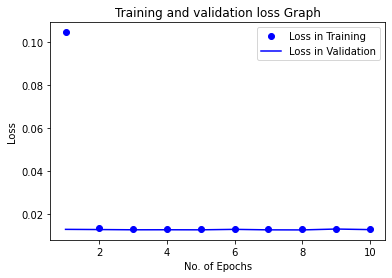

In [154]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Loss in Training')
plt.plot(epochs,val_loss,'b',label='Loss in Validation')
plt.title('Training and validation loss Graph')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Calculating Spearman's Correlation Coefficient score**

In [25]:
predictions = model.predict(X_test)
print(predictions)
Get_spearmann_score(predictions, Y_test) 

[[0.8390302  0.77952087]
 [0.8365354  0.8153412 ]
 [0.84984165 0.7925437 ]
 ...
 [0.8660579  0.814792  ]
 [0.8379957  0.7794547 ]
 [0.8497516  0.7951453 ]]
The Spearmann's correlation coefficient is: 0.076
The Spearmann's correlation coefficient is: 0.047


As we can see here using Inception Features gives us poor outcomes.

# **2. Using Captions Features**

**Defining Function to load the captions into dataframes and to pre-process the dataset.**

In [0]:
# Function to load captions.
def load_captions(filename):
    video_name = []
    captions = []
    dataframe = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #the split function used here is to divide the line into two parts because it contains two different words.
            video_name.append(pair[0]) #First Word as Video Name
            captions.append(pair[1]) #Second as caption of the video.
        dataframe['video']=video_name
        dataframe['caption']=captions
    return dataframe

**Giving path to the dataset in the notebook**

In [0]:
#Loading ground truth dataset
CSV_Path ='/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv'
dataset = pd.read_csv(CSV_Path)

#Loading Captions
Captions_Path ='/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
captions = load_captions(Captions_Path)

In [132]:
print(dataset)

               video  ...  nb_long-term_annotations
0        video3.webm  ...                        13
1        video4.webm  ...                        12
2        video6.webm  ...                        10
3        video8.webm  ...                        11
4       video10.webm  ...                        10
...              ...  ...                       ...
5995  video7488.webm  ...                         9
5996  video7489.webm  ...                        31
5997  video7491.webm  ...                        11
5998  video7492.webm  ...                        16
5999  video7493.webm  ...                        13

[6000 rows x 5 columns]


In [67]:
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


**Cleaning Dataset** 
* Remove punctutations and stopwords from captions.
* Replace punctuation marks with white spaces.
* Coverting words to lower case

In [0]:
# Loading the nltk stopwords of English
stopwords = nltk.corpus.stopwords.words('english')

In [69]:
# Removing punctuations and stop words from captions
ProgressBar = pyprind.ProgBar(len(captions['caption']), title='Counting words ...')
for i, cap in enumerate(captions['caption']):
    # Replacing punctuation marks with spaces and converting words to lower case. 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    # Finally removing the stopwords
    RemovingStopwords= ' '.join([word for word in text.split() if word not in stopwords])
    captions.loc[i,'caption'] = RemovingStopwords #updating the original captions 
    ProgressBar.update()

Counting words ...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [70]:
captions.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


**Using Bag of Words for the captions.**

In [0]:
# Using bag of words for the captions we combined
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer.fit_transform(captions.caption).toarray()

In [72]:
# Lets check the type of our captions_bag it should be numpy array as we converted it in previous code.
print(type(captions_bag))
# Shape of captions_bag it should be 2D Array.
print(captions_bag.shape)

<class 'numpy.ndarray'>
(6000, 3112)


In [0]:
X = captions_bag
y = dataset[['short-term_memorability','long-term_memorability']].values

**Splitting Dataset into Training set and Test set.**

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [82]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)


**Building the RandomForest Model**

In [83]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100)
captions_rf.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
# Predicting on Test Dataset.
captions_pred = captions_rf.predict(X_test)

Text(0, 0.5, 'Actual')

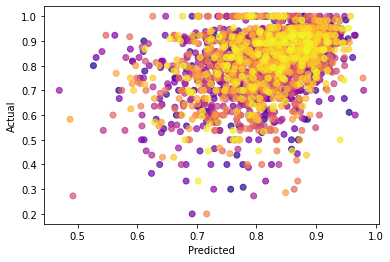

In [85]:
t = np.arange(2400)
plt.scatter(captions_pred,y_test, c=t, cmap='plasma', alpha=0.7)
plt.xlabel('Predicted')
plt.ylabel('Actual')

**Calculating Spearman's Correlation Coefficient score**

In [86]:
Get_spearmann_score(captions_pred, y_test)

The Spearmann's correlation coefficient is: 0.414
The Spearmann's correlation coefficient is: 0.174


**Building the Support Vector Regression (SVR) Model**

In [0]:
svr_X = captions_bag
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X, svr_y_short)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X, svr_y_long)

**Standard Scaler**
Using StandardScaler to scalarize the training features into a distributed values with Standard Derivation of 1. We are using this to make the model easier to learn the features.

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [90]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

**Calculating Spearman's Correlation Coefficient score**

In [92]:
# Calculating Spearman's Correlation Coefficient
Get_spearmann_score(short_pred, short_y_test)
Get_spearmann_score(long_pred, long_y_test)

The Spearmann's correlation coefficient is: 0.336
The Spearmann's correlation coefficient is: 0.173


# **3. Using HMP Feature**

**Defining Function to load the HMP features and to pre-process the dataset.**

In [0]:
def read_HMP(fname):
    with open(fname) as f:
        for line in f:
            pairs=line.split() # Splitting the line as it contains two different words.
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

**Fetching HMP features**

In [0]:
HMP_feature_list= []
video_names_list = []
path = 'C3D/*.txt'
for filename in glob.glob('HMP/*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

**Transforming HMP features into dataframe**

In [0]:
HMP_features = pd.DataFrame(np.array(HMP_feature_list).reshape(6000,6075))
HMP_features["video"] = video_names_list

In [54]:
HMP_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074,video
0,0.012099,0.001466,0.000017,0.0,0.000683,0.000007,0.0,0.000000,0.000007,0.0,0.0,0.0,0.0,0.000170,0.000002,0.0,0.000002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000239,0.000324,0.000151,0.000106,0.000050,0.000014,0.000156,0.000123,0.000031,0.000163,0.000177,0.000097,0.000047,0.000021,0.000002,0.000019,0.000021,0.000000,0.000002,0.000009,0.000002,0.000059,0.000024,0.000007,0.000057,0.000052,0.000012,0.000026,0.000007,0.000014,0.000057,0.000028,0.000007,0.000059,0.000097,0.000012,0.000135,0.000111,0.000076,video6634
1,0.078170,0.013597,0.000122,0.0,0.005590,0.000074,0.0,0.000000,0.000026,0.0,0.0,0.0,0.0,0.001137,0.000017,0.0,0.000000,0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000069,0.000091,0.000026,0.000061,0.000022,0.000004,0.000091,0.000048,0.000013,0.000043,0.000095,0.000030,0.000043,0.000013,0.000000,0.000039,0.000026,0.000000,0.000009,0.000013,0.000000,0.000069,0.000026,0.000004,0.000143,0.000139,0.000009,0.000017,0.000043,0.000022,0.000043,0.000026,0.000004,0.000078,0.000074,0.000022,0.000052,0.000082,0.000061,video6633
2,0.112506,0.014053,0.000263,0.0,0.043205,0.000560,0.0,0.000005,0.000364,0.0,0.0,0.0,0.0,0.002472,0.000206,0.0,0.000002,0.000064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000310,0.000629,0.000263,0.000145,0.000061,0.000002,0.000098,0.000248,0.000007,0.000125,0.000354,0.000076,0.000135,0.000049,0.000000,0.000074,0.000103,0.000000,0.000012,0.000039,0.000002,0.000066,0.000012,0.000002,0.000098,0.000221,0.000012,0.000029,0.000076,0.000022,0.000261,0.000069,0.000000,0.000157,0.000558,0.000017,0.000285,0.000504,0.000179,video6639
3,0.066072,0.012682,0.000283,0.0,0.006425,0.000375,0.0,0.000002,0.000174,0.0,0.0,0.0,0.0,0.002373,0.000152,0.0,0.000002,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000278,0.000744,0.000484,0.000155,0.000077,0.000000,0.000161,0.000563,0.000084,0.000132,0.000375,0.000358,0.000227,0.000075,0.000002,0.000077,0.000135,0.000007,0.000009,0.000011,0.000007,0.000190,0.000049,0.000004,0.000305,0.001002,0.000099,0.000038,0.000106,0.000075,0.000495,0.000210,0.000002,0.000342,0.002027,0.000124,0.000307,0.001239,0.001047,video6635
4,0.030360,0.005834,0.000169,0.0,0.006578,0.000542,0.0,0.000016,0.000373,0.0,0.0,0.0,0.0,0.001041,0.000113,0.0,0.000007,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000696,0.001019,0.000197,0.000239,0.000111,0.000011,0.000298,0.000389,0.000056,0.000291,0.000395,0.000090,0.000115,0.000052,0.000002,0.000054,0.000070,0.000007,0.000014,0.000041,0.000011,0.000124,0.000045,0.000005,0.000176,0.000181,0.000029,0.000052,0.000090,0.000027,0.000199,0.000061,0.000002,0.000228,0.000253,0.000023,0.000359,0.000375,0.000088,video6637


In [0]:
# Ground truth from drive 
ground_truth = pd.read_csv('/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv')

In [0]:
# Dropping the unnecessary columns as this is of no use.
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [0]:
ground_truth['video'] = ground_truth['video'].apply(lambda x : x.split('.')[0]) #Using lambda to spit all the video test file after (.) fullstop in it.

In [58]:
ground_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


**Merging ground_truth and HMP_features into a dataframe**

In [0]:
df = pd.merge(ground_truth, HMP_features , on='video') #Merging ground_truth and HMP_Features csv file together.

In [60]:
df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video3,0.924,0.846,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,0.0,0.0,0.0,0.002795,0.000054,0.0,0.000000,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,video4,0.923,0.667,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,0.0,0.0,0.0,0.000246,0.000024,0.0,0.000000,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,video6,0.863,0.700,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,0.0,0.0,0.0,0.002046,0.000061,0.0,0.000000,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,video8,0.922,0.818,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,0.0,0.0,0.0,0.002496,0.000149,0.0,0.000011,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,video10,0.950,0.900,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,0.0,0.0,0.0,0.000147,0.000020,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


**Creating features and Target required for the Model.**

In [0]:
X = df.iloc[:,3:6078].values #Features
Y = df.iloc[:, 1:3].values #Target

In [0]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

**Building the Model using RandomForest Regression Model**

In [99]:
from sklearn.ensemble import RandomForestRegressor
regressor1 = RandomForestRegressor(n_estimators=100)
regressor1.fit(X_train, Y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

**Spearman Correlation Cofficient**
Lets see how well and related the relationship is between the Predicted file and actual file. Spearman Score gives us the score and shows the relationship between two variables.

**Calculating Spearman's Correlation Coefficient score**

In [100]:
Y_pred1 = regressor1.predict(X_test)
Get_spearmann_score(Y_pred1, Y_test)

The Spearmann's correlation coefficient is: 0.304
The Spearmann's correlation coefficient is: 0.127


**Building the Model using Decision Tree Model**

In [101]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Calculating Spearman's Correlation Coefficient score**

In [103]:
Y_pred2 = regressor2.predict(X_test)
Get_spearmann_score(Y_pred2, Y_test)

The Spearmann's correlation coefficient is: 0.043
The Spearmann's correlation coefficient is: 0.027


# **PART V. Choosing Perfect Model with Features** 

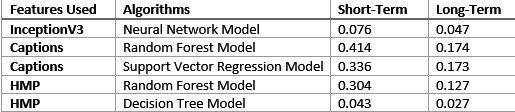

In [128]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Machine Learning/scores.jpeg",width="600",height="150")

In [129]:
# Spearman's score of Captions when used with Random Forest Model
# Using the best model i.e. Random Forest Model with n_estimators=100 in captions 
Get_spearmann_score(captions_pred, y_test)

The Spearmann's correlation coefficient is: 0.414
The Spearmann's correlation coefficient is: 0.174


# **PART VI. Predicting the Final Results**

**Building RandomForest Model and Prediction**

In [0]:
X = captions_bag
y = dataset[['short-term_memorability','long-term_memorability']].values

In [106]:
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [107]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
# Loading the test set captions
 TestSet_Captions_Path ='/content/drive/My Drive/Machine Learning/Assignment Dataset/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
 TestSet_Captions = load_captions(TestSet_Captions_Path)

In [112]:
 TestSet_Captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [113]:
# Removing punctuations and stop words from captions (E.g.: and, or, etc.)
# setup prograss tracker to calculate the execution time remaining.
 ProgressBar = pyprind.ProgBar(len(TestSet_Captions['caption']), title=' Counting words...')
for i, cap in enumerate(TestSet_Captions['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    # Removing stopwords for test set
    RemovingStopwords= ' '.join([word for word in text.split() if word not in stopwords])
    TestSet_Captions.loc[i,'caption'] = RemovingStopwords 
    ProgressBar.update() 

 Counting words...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [114]:
TestSet_Captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [115]:
# Implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
TestSet_Captions_bag = vectorizer.fit_transform(TestSet_Captions.caption).toarray()
type(TestSet_Captions_bag)

numpy.ndarray

In [116]:
print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(TestSet_Captions_bag[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


**Predicting the scores on final data and Exporting the Results**

In [0]:
test_pred = rf_regressor.predict(TestSet_Captions_bag)

In [0]:
pred = pd.DataFrame()

In [0]:
pred['short-term'] = test_pred[:,0]

In [0]:
pred['long-term'] = test_pred[:,1]

In [122]:
pred.head()

,short-term,long-term
0,0.854338,0.741889
1,0.891458,0.805723
2,0.821762,0.759397
3,0.917545,0.801524
4,0.862892,0.713907


In [123]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.847407,0.753607
std,0.033486,0.068031
min,0.685295,0.443260
25%,0.830299,0.722987
50%,0.849766,0.758861
75%,0.869481,0.795832
max,0.952947,0.946862


In [0]:
pred.to_csv("/content/Results.csv",index=False) #We don't need index as it is not required.
from google.colab import files
files.download("/content/Results.csv") 

In [125]:
submission = pd.read_csv('/content/Results.csv')
submission.head()

,short-term,long-term
0,0.854338,0.741889
1,0.891458,0.805723
2,0.821762,0.759397
3,0.917545,0.801524
4,0.862892,0.713907
